In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import matplotlib
import matplotlib.pyplot as plt
from math import log
import seaborn as sb

# Loading Reference name to Taxa Id file

In [3]:
ref = "/mnt/scratch2/avi/meta-map/kraken/KrakenDB/seqid2taxid.map"
with open(ref) as f:
    refId2TaxId = pd.read_csv(f, header=None, sep="\t", names=["refName", "refId"])

# Loading Taxonomy Tree
### Taxum ID , Taxum Rank , Taxum Parent ID

In [4]:
tf = "/mnt/scratch2/avi/meta-map/kraken/KrakenDB/taxonomy/nodes.dmp"
taxa = []
id2rank = {}
with open(tf) as f:
    for line in f:
        toks = line.rstrip("\t|\n").split("\t|\t")
        taxa += [[int(toks[0]), int(toks[1]), toks[2]]]
        id2rank[int(toks[0])] = toks[2]
taxa_df = pd.DataFrame.from_records(taxa)
taxa_df.columns = ["taxaId", "pid", "rank"]

In [5]:
taxa_df.head()

,taxaId,pid,rank
0,1,1,no rank
1,2,131567,superkingdom
2,6,335928,genus
3,7,6,species
4,9,32199,species


# Truth

In [6]:
def mard(df, c1, c2):
    a = abs(df[c1]-df[c2])/(df[c1]+df[c2])
    return a.sum()/a.count()
def calc_precRecall(truth_pred):
    alltruth = truth_pred['trueCount'].sum()
    tp = truth_pred[['predCount', 'trueCount']].min(axis=1).sum()
    recall = tp/max(alltruth, 1)
    predictedP = truth_pred['predCount'].sum()
    prec = tp/max(predictedP, 1)
    f1 = 2*(prec*recall)/max((prec+recall), 1)
    return [prec, recall, f1]
def calc_presAbs_precRecall(truth_pred):
    alltruth = len(truth_pred[truth_pred['trueId'] != 0])
    tp = len(truth_pred[(truth_pred['predId'] != 0) & (truth_pred['trueId'] != 0)])
    recall = tp/max(alltruth, 1)
    predictedP = len(truth_pred[truth_pred['predId'] != 0])
    prec = tp/max(predictedP, 1)
    f1 = 2*(prec*recall)/max((prec+recall), 1)
    return [prec, recall, f1]

In [7]:
# assumption:
# 0: id, 1: rank, 2: count, 3: aggregatedCount
def truth_aggregate(taxa_df, df, keepAll = False):
    res = defaultdict(lambda:0, {})
    for index, row in df.iterrows():
        nodeId = row.iloc[0]
        count = row.iloc[2]
        res[(nodeId, row.iloc[1])] = count # id, rank --> aggregated count
        # increase the count of any inner node that is an ancestor of this node up until root
        while (nodeId != 1):
            parId = taxa_df[taxa_df['taxaId'] == nodeId].pid.values[0]
            pnode = taxa_df[taxa_df['taxaId'] == parId]
            res[(parId, pnode['rank'].values[0])] += count
            nodeId = parId
    res_list = []
    for k, v in res.items(): # put the three values in the list
        res_list.append([k[0], k[1], v])
    return pd.DataFrame(res_list, columns=['trueId', 'trueRank', 'trueCount']) # convert it to a dataframe and return

In [8]:
# assumption:
# 0: id, 1: rank, 2: count
def aggregate(taxa_df, df, level = 'species', keepAll = False):
    res = defaultdict(lambda:0, {})
    for index, row in df.iterrows():
        node = [row.iloc[0], row.iloc[1], row.iloc[2]]
        while (node[1] != level and node[0] != 1):
            parId = taxa_df[taxa_df['taxaId'] == node[0]].pid.values[0]
            pnode = taxa_df[taxa_df['taxaId'] == parId]
            node = [pnode.taxaId.values[0], pnode['rank'].values[0], node[2]]
        if node[1] == level:
            res[node[0]] += node[2]
    return pd.DataFrame(list(res.items()), columns=['trueId', 'trueCount'])

In [9]:
truthfile = '/mnt/scratch2/avi/meta-map/kraken/meta/truth.txt'
truth = pd.read_csv(truthfile, sep="\t")

In [10]:
truth.head()

,taxid,counts,species,size,dataset
0,79329,24666,Chitinophaga pinensis,9127347,Huttenhower_HC1
1,1836,22195,Saccharopolyspora erythraea,8079083,Huttenhower_HC1
2,152480,20654,Burkholderia ambifaria,8095900,Huttenhower_HC1
3,182640,20483,Kribbella flavida,7579488,Huttenhower_HC1
4,80866,18289,Delftia acidovorans,6823175,Huttenhower_HC1


In [30]:
lc4_truth = truth[truth['dataset'] == 'Huttenhower_LC4']
lc4_truth.head(1)

,taxid,counts,species,size,dataset
275,284016,162062,Phenylobacterium zucineum,4379231,Huttenhower_LC4


In [31]:
cedar = pd.read_csv('/mnt/scratch2/fatemeh/krakpuff/singleEnd/krakpuff_output/LC4_species_unfilt.cedar', sep='\t')
cedar.head(1)

,taxaId,taxaRank,count
0,248026,species,1.00009


In [38]:
bracken = pd.read_csv('/mnt/scratch2/fatemeh/krakpuff/kraken/tst/bracken/sample_output_species_abundance.txt', sep='\t')
bracken.head(1)

,name,taxonomy_id,taxonomy_lvl,kraken_assigned_reads,added_reads,new_est_reads,fraction_total_reads
0,Phenylobacterium zucineum,284016,S,153407,0,153407,0.65609


In [48]:
bracken_truth=pd.merge(lc4_truth,bracken, how='outer', left_on='taxid', right_on='taxonomy_id').fillna(0)
print(bracken_truth[['counts', 'new_est_reads']].corr(method='spearman'))
print('\n')
print(bracken_truth[['counts', 'new_est_reads']].corr(method='pearson'))
print('\n')
print(mard(bracken_truth, 'counts', 'new_est_reads'))

                 counts  new_est_reads
counts         1.000000       0.989229
new_est_reads  0.989229       1.000000


                counts  new_est_reads
counts         1.00000        0.99997
new_est_reads  0.99997        1.00000


0.183610052648


In [52]:
cedar_truth=pd.merge(lc4_truth,cedar, how='outer', left_on='taxid', right_on='taxaId')
print(cedar_truth[['counts', 'count']].corr(method='spearman'))
print('\n')
print(cedar_truth[['counts', 'count']].corr(method='pearson'))
print('\n')
print(mard(cedar_truth, 'counts', 'count'))

        counts  count
counts     1.0    1.0
count      1.0    1.0


        counts  count
counts     1.0    1.0
count      1.0    1.0


0.0697596962836


# Calculate aggregated values at different levels of the truth once and for all

In [11]:
#ds_truth = {}
#for dataset in ['HC1', 'HC2', 'LC1', 'LC2', 'LC3', 'LC4', 'LC5', 'LC6', 'LC7', 'LC8']:
    
#     dataset_truth = truth[truth['dataset'] == 'Huttenhower_{}'.format(dataset)]
#     dataset_truth = pd.merge(dataset_truth, taxa_df, left_on='taxid', right_on='taxaId')
#     dataset_truth = dataset_truth[['taxaId', 'rank', 'counts']]
#     dataset_truth.columns = [['trueId', 'rank', 'trueCount']]
#     ds_truth[dataset] = truth_aggregate(taxa_df, dataset_truth)
#     for level in ['species', 'genus', 'family', 'order', 'class', 'phylum']:
#         key = dataset + '-' + level
#         ds_truth[key] = aggregate(taxa_df, dataset_truth, level)

In [12]:
# for k, v in ds_truth.items():
#     v.to_csv('/mnt/scratch2/fatemeh/krakpuff/truth_files/{}.truth'.format(k))

In [21]:
ds_truth = {}
for dataset in ['HC1', 'HC2', 'LC1', 'LC2', 'LC3', 'LC4', 'LC5', 'LC6', 'LC7', 'LC8']:
    for level in ['species', 'genus', 'family', 'order', 'class', 'phylum']:
        key = dataset + '-' + level
        ds_truth[key] = pd.DataFrame.from_csv('/mnt/scratch2/fatemeh/krakpuff/truth_files/{}.truth'.format(key))

In [13]:
def merge_clark_results(clarkf, clarkl):
#clarkf = '/mnt/scratch2/fatemeh/krakpuff/clark_reports/{}_species.rpt'
    clark_df = {}
    clark_spec_ag = {}
    for dataset in ['HC1', 'HC2', 'LC1', 'LC2', 'LC3', 'LC4', 'LC5', 'LC6', 'LC7', 'LC8']:
        print(dataset)
        clark = pd.read_csv(clarkf.format(dataset))
        clark['TaxID'] = clark['TaxID'].apply(pd.to_numeric, errors='coerce')
        clark['TaxID'] = clark['TaxID'].fillna(0.0).astype(int)
        clark = pd.merge(clark, taxa_df, left_on='TaxID', right_on='taxaId')
        clark_spec_ag[dataset] = truth_aggregate(taxa_df, clark[['TaxID', 'rank', 'Count']])
        clark_spec_ag[dataset].columns = ['predId', 'rank', 'predCount']
        clark_l = pd.DataFrame(columns=['TaxID', 'rank', 'Count'])
        #clarkl = '/mnt/scratch2/fatemeh/krakpuff/clark_reports/{}_{}.rpt'
        for level in ['genus', 'family', 'order', 'class', 'phylum']:
            print(level)
            clark= pd.read_csv(clarkl.format(dataset, level))
            clark['TaxID'] = clark['TaxID'].apply(pd.to_numeric, errors='coerce')
            clark['TaxID'] = clark['TaxID'].fillna(0.0).astype(int)
            clark = pd.merge(clark, taxa_df, left_on='TaxID', right_on='taxaId')
            clark_l = clark_l.append(clark[['TaxID', 'rank', 'Count']])
        print(clark_l['rank'].unique())
        clark_ag = pd.merge(clark_spec_ag[dataset], clark_l, left_on='predId', right_on='TaxID', how='outer').fillna(0)
        clark_ag['totCount'] = clark_ag[['predCount', 'Count']].max(axis=1)
        clark_ag['id'] = clark_ag[['predId', 'TaxID']].max(axis=1)
        clark_ag = pd.merge(clark_ag[['id', 'totCount']], taxa_df, left_on='id', right_on='taxaId')
        clark_df[dataset] = clark_ag[['id', 'rank', 'totCount']]
        clark_df[dataset].columns = [['predId', 'predRank', 'predCount']] 
    return clark_df

In [14]:
def prepare(truthf, krakenf, pufferf, clark1_df, statf):
    levels = ['species', 'genus', 'family', 'order', 'class', 'phylum']
    stats = []
    ds_puffer = {}
    ds_kraken = {}
    ds_clark = {}
    for dataset in ['HC1', 'HC2', 'LC1', 'LC2', 'LC3', 'LC4', 'LC5', 'LC6', 'LC7', 'LC8']:
        print(dataset)
        ds_truth[dataset] = pd.DataFrame.from_csv(truthf.format(dataset))
        #krakenf = '/mnt/scratch2/avi/meta-map/kraken/krakOut/{}.rpt'.format(dataset)
        krakenf_formatted = krakenf.format(dataset)
        kraken = pd.read_csv(krakenf_formatted, sep="\t", header=None)
        kraken.columns = ['totalPerc', 'totalCount', 'count', 'r', 'id', 'rankScientificName']
        kraken = kraken[['id', 'totalCount']]
        kraken = pd.merge(kraken, taxa_df, left_on='id', right_on='taxaId')
        kraken = kraken[['id','rank', 'totalCount']]
        kraken.columns = ['predId', 'predRank', 'predCount']

        #pufferf = '/mnt/scratch2/fatemeh/krakpuff/{}_species0_2.out'.format(dataset)
        pufferf_formatted = pufferf.format(dataset)
        puffer = pd.read_csv(pufferf_formatted, sep="\t")
        puffer = puffer[puffer['taxaId'] > 0]
        puffer.columns = ['predId', 'predRank', 'predDirectCount', 'predCount']
       
        #clark_df = pd.read_csv(clarkf.format(dataset))
        #clark_df['TaxID'] = clark_df['TaxID'].apply(pd.to_numeric, errors='coerce')
        #clark_df['TaxID'] = clark_df['TaxID'].fillna(0.0).astype(int)
        #clark = pd.merge(clark_df, taxa_df, left_on='TaxID', right_on='taxaId')
        #clark = clark[['TaxID', 'rank', 'Count']]
        #clark.columns = ['predId', 'predRank', 'predCount']
        
        ds_truth_puffer_joined = pd.merge(ds_truth[dataset], puffer, how='outer', left_on='trueId', right_on='predId').fillna(0)
        #ds_truth_puffer_joined.columns = ['trueId', 'trueCount', 'predId', 'predCount']
        puff_pears = ds_truth_puffer_joined[['trueCount', 'predCount']].corr(method='pearson')['predCount']['trueCount']
        puff_spear = ds_truth_puffer_joined[['trueCount', 'predCount']].corr(method='spearman')['predCount']['trueCount']
        puff_mard = mard(ds_truth_puffer_joined, 'trueCount', 'predCount')
        puff_precrecf1 = calc_precRecall(ds_truth_puffer_joined)
        puff_presAb_precrecf1 = calc_presAbs_precRecall(ds_truth_puffer_joined)
        
        ds_truth_kraken_joined = pd.merge(ds_truth[dataset], kraken, how='outer', left_on='trueId', right_on='predId').fillna(0)
        #ds_truth_kraken_joined.columns = ['trueId', 'trueCount', 'predId', 'predCount']
        kraken_pears = ds_truth_kraken_joined[['trueCount', 'predCount']].corr(method='pearson')['predCount']['trueCount']
        kraken_spear = ds_truth_kraken_joined[['trueCount', 'predCount']].corr(method='spearman')['predCount']['trueCount']
        kraken_mard = mard(ds_truth_kraken_joined, 'trueCount', 'predCount')
        kraken_precrecf1 = calc_precRecall(ds_truth_kraken_joined)
        kraken_presAb_precrecf1 = calc_presAbs_precRecall(ds_truth_kraken_joined)
        
        ds_truth_clark_joined = pd.merge(ds_truth[dataset], clark1_df[dataset], how='outer', left_on='trueId', right_on='predId').fillna(0)
        #ds_truth_kraken_joined.columns = ['trueId', 'trueCount', 'predId', 'predCount']
        clark_pears = ds_truth_clark_joined[['trueCount', 'predCount']].corr(method='pearson')['predCount']['trueCount']
        clark_spear = ds_truth_clark_joined[['trueCount', 'predCount']].corr(method='spearman')['predCount']['trueCount']
        clark_mard = mard(ds_truth_clark_joined, 'trueCount', 'predCount')
        clark_precrecf1 = calc_precRecall(ds_truth_clark_joined)
        clark_presAb_precrecf1 = calc_presAbs_precRecall(ds_truth_clark_joined)

        stats += [(dataset, 'all',
                    puff_pears, puff_spear, puff_mard, 
                   puff_precrecf1[0], puff_precrecf1[1], puff_precrecf1[2],
                   puff_presAb_precrecf1[0], puff_presAb_precrecf1[1], puff_presAb_precrecf1[2],
                    kraken_pears, kraken_spear, kraken_mard, 
                   kraken_precrecf1[0], kraken_precrecf1[1], kraken_precrecf1[2],
                  kraken_presAb_precrecf1[0], kraken_presAb_precrecf1[1], kraken_presAb_precrecf1[2],
                  clark_pears, clark_spear, clark_mard, 
                   clark_precrecf1[0], clark_precrecf1[1], clark_precrecf1[2],
                  clark_presAb_precrecf1[0], clark_presAb_precrecf1[1], clark_presAb_precrecf1[2])]
        
        
        ############# NO RANK #################
        key = dataset + '-norank'
        ds_truth[key] = ds_truth[dataset][~ds_truth[dataset]['trueRank'].isin(levels)]
        ds_puffer[key] = puffer[~puffer['predRank'].isin(levels)][['predId', 'predCount']]#aggregate(taxa_df, puffer, level)
        ds_kraken[key] = kraken[~kraken['predRank'].isin(levels)][['predId', 'predCount']]#aggregate(taxa_df, kraken, level)
        ds_truth_puffer_joined = pd.merge(ds_truth[key], ds_puffer[key], how='outer', left_on='trueId', right_on='predId').fillna(0)
        #ds_truth_puffer_joined.columns = ['trueId', 'trueCount', 'predId', 'predCount']
        puff_pears = ds_truth_puffer_joined[['trueCount', 'predCount']].corr(method='pearson')['predCount']['trueCount']
        puff_spear = ds_truth_puffer_joined[['trueCount', 'predCount']].corr(method='spearman')['predCount']['trueCount']
        puff_mard = mard(ds_truth_puffer_joined, 'trueCount', 'predCount')
        puff_precrecf1 = calc_precRecall(ds_truth_puffer_joined)
        puff_presAb_precrecf1 = calc_presAbs_precRecall(ds_truth_puffer_joined)

        ds_truth_kraken_joined = pd.merge(ds_truth[key], ds_kraken[key], how='outer', left_on='trueId', right_on='predId').fillna(0)
        #ds_truth_kraken_joined.columns = ['trueId', 'trueCount', 'predId', 'predCount']
        kraken_pears = ds_truth_kraken_joined[['trueCount', 'predCount']].corr(method='pearson')['predCount']['trueCount']
        kraken_spear = ds_truth_kraken_joined[['trueCount', 'predCount']].corr(method='spearman')['predCount']['trueCount']
        kraken_mard = mard(ds_truth_kraken_joined, 'trueCount', 'predCount')
        kraken_precrecf1 = calc_precRecall(ds_truth_kraken_joined)
        kraken_presAb_precrecf1 = calc_presAbs_precRecall(ds_truth_kraken_joined)

        stats += [(dataset, 'norank',
                puff_pears, puff_spear, puff_mard, 
                   puff_precrecf1[0], puff_precrecf1[1], puff_precrecf1[2],
                   puff_presAb_precrecf1[0], puff_presAb_precrecf1[1], puff_presAb_precrecf1[2],
                kraken_pears, kraken_spear, kraken_mard, 
                   kraken_precrecf1[0], kraken_precrecf1[1], kraken_precrecf1[2],
                  kraken_presAb_precrecf1[0], kraken_presAb_precrecf1[1], kraken_presAb_precrecf1[2],
                  0,0,0,0,0,0,0,0,0)]
            
        for level in levels:
            #print(level)
            key = dataset + '-' + level
            ds_truth[key] = pd.read_csv(truthf.format(key))
            #ds_truth[key] = aggregate(taxa_df, dataset_truth, level)
            ds_puffer[key] = puffer[puffer['predRank'] == level][['predId', 'predCount']]#aggregate(taxa_df, puffer, level)
            ds_kraken[key] = kraken[kraken['predRank'] == level][['predId', 'predCount']]#aggregate(taxa_df, kraken, level)
            ds_clark[key] = clark1_df[dataset][clark1_df[dataset]['predRank'] == level][['predId', 'predCount']]
            
            ds_truth_puffer_joined = pd.merge(ds_truth[key], ds_puffer[key], how='outer', left_on='trueId', right_on='predId').fillna(0)
            #ds_truth_puffer_joined.columns = ['trueId', 'trueCount', 'predId', 'predCount']
            puff_pears = ds_truth_puffer_joined[['trueCount', 'predCount']].corr(method='pearson')['predCount']['trueCount']
            puff_spear = ds_truth_puffer_joined[['trueCount', 'predCount']].corr(method='spearman')['predCount']['trueCount']
            puff_mard = mard(ds_truth_puffer_joined, 'trueCount', 'predCount')
            puff_precrecf1 = calc_precRecall(ds_truth_puffer_joined)
            puff_presAb_precrecf1 = calc_presAbs_precRecall(ds_truth_puffer_joined)
            
            ds_truth_kraken_joined = pd.merge(ds_truth[key], ds_kraken[key], how='outer', left_on='trueId', right_on='predId').fillna(0)
            #ds_truth_kraken_joined.columns = ['trueId', 'trueCount', 'predId', 'predCount']
            kraken_pears = ds_truth_kraken_joined[['trueCount', 'predCount']].corr(method='pearson')['predCount']['trueCount']
            kraken_spear = ds_truth_kraken_joined[['trueCount', 'predCount']].corr(method='spearman')['predCount']['trueCount']
            kraken_mard = mard(ds_truth_kraken_joined, 'trueCount', 'predCount')
            kraken_precrecf1 = calc_precRecall(ds_truth_kraken_joined)
            kraken_presAb_precrecf1 = calc_presAbs_precRecall(ds_truth_kraken_joined)
            
            ds_truth_clark_joined = pd.merge(ds_truth[key], ds_clark[key], how='outer', left_on='trueId', right_on='predId').fillna(0)
            #ds_truth_kraken_joined.columns = ['trueId', 'trueCount', 'predId', 'predCount']
            clark_pears = ds_truth_clark_joined[['trueCount', 'predCount']].corr(method='pearson')['predCount']['trueCount']
            clark_spear = ds_truth_clark_joined[['trueCount', 'predCount']].corr(method='spearman')['predCount']['trueCount']
            clark_mard = mard(ds_truth_clark_joined, 'trueCount', 'predCount')
            clark_precrecf1 = calc_precRecall(ds_truth_clark_joined)
            clark_presAb_precrecf1 = calc_presAbs_precRecall(ds_truth_clark_joined)
            
            stats += [(dataset, level,
                    puff_pears, puff_spear, puff_mard, 
                       puff_precrecf1[0], puff_precrecf1[1], puff_precrecf1[2],
                       puff_presAb_precrecf1[0], puff_presAb_precrecf1[1], puff_presAb_precrecf1[2],
                    kraken_pears, kraken_spear, kraken_mard, 
                       kraken_precrecf1[0], kraken_precrecf1[1], kraken_precrecf1[2],
                      kraken_presAb_precrecf1[0], kraken_presAb_precrecf1[1], kraken_presAb_precrecf1[2],
                      clark_pears, clark_spear, clark_mard, 
                       clark_precrecf1[0], clark_precrecf1[1], clark_precrecf1[2],
                      clark_presAb_precrecf1[0], clark_presAb_precrecf1[1], clark_presAb_precrecf1[2])]
    stats_df = pd.DataFrame.from_records(stats, columns = ['dataset', 'level', 
                                   'puff_pearson', 'puff_spearman', 'puff_mard', 
                                                           'puff_cnt_prec', 'puff_cnt_rec', 'puff_cnt_f1',
                                                           'puff_prec', 'puff_rec', 'puff_f1',
                                     'kraken_pearson', 'kraken_spearman', 'kraken_mard', 
                                                           'kraken_cnt_prec', 'kraken_cnt_rec', 'kraken_cnt_f1',
                                                           'kraken_prec', 'kraken_rec', 'kraken_f1',
                                                          'clark_pearson', 'clark_spearman', 'clark_mard', 
                                                           'clark_cnt_prec', 'clark_cnt_rec', 'clark_cnt_f1',
                                                           'clark_prec', 'clark_rec', 'clark_f1']) 
    stats_df['krakpuff_mard_diff'] = stats_df['kraken_mard']-stats_df['puff_mard']
    stats_df['puffkrak_spearman_diff'] = stats_df['puff_spearman']-stats_df['kraken_spearman']
    stats_df['puffkrak_pearson_diff'] = stats_df['puff_pearson']-stats_df['kraken_pearson']
    stats_df['puffkrak_cnt_f1_diff'] = stats_df['puff_cnt_f1']-stats_df['kraken_cnt_f1']
    stats_df['puffkrak_f1_diff'] = stats_df['puff_f1']-stats_df['kraken_f1']
    
    stats_df.to_csv(statf)
    return (stats_df, ds_kraken, ds_puffer)

In [15]:
def draw_plots(stats_df):

    datasets = ['HC1', 'HC2', 'LC1', 'LC2', 'LC3', 'LC4', 'LC5', 'LC6', 'LC7', 'LC8']
    levels = ['all', 'species']#, 'genus', 'family', 'order', 'class', 'phylum', 'norank']
    statistics = ['spearman', 'pearson', 'mard', 'f1', 'cnt_f1']


    for st in statistics:
        print('\n\n{}'.format(st))
        plt.subplots(3, 3, figsize=[30, 10])
        index = np.arange(len(datasets))
        bar_width = 0.35
        opacity = 0.8

        i = 1
        for level in levels:
            plt.subplot(3, 3, i)
            plt.bar(index, stats_df[stats_df['level'] == level]['puff_{}'.format(st)], bar_width,
                             alpha=opacity,
                             color='b',
                             label='Puffer')

            plt.bar(index + bar_width, stats_df[stats_df['level'] == level]['kraken_{}'.format(st)], bar_width,
                             alpha=opacity,
                             color='g',
                             label='Kraken')

            plt.bar(index + 2 * bar_width, stats_df[stats_df['level'] == level]['clark_{}'.format(st)], bar_width,
                             alpha=opacity,
                             color='r',
                             label='Clark')

            #plt.xlabel('Datasets', fontsize=14)
            plt.ylabel(st, fontsize=20)
            #plt.title('Scores by person')
            plt.xticks(index + bar_width, stats_df[stats_df['level'] == level]['dataset'])
            plt.legend()
            plt.title(level, fontsize=22)
            i += 1
        plt.tight_layout()
        plt.show()

In [16]:
def draw_box_plots(stats_df, levels, xaxis, hues, title):

    datasets = ['HC1', 'HC2', 'LC1', 'LC2', 'LC3', 'LC4', 'LC5', 'LC6', 'LC7', 'LC8']
    #levels = ['all', 'species']#, 'genus', 'family', 'order', 'class', 'phylum', 'norank']
    statistics = ['spearman', 'pearson', 'mard', 'f1']#, 'cnt_f1']

    for st in statistics:
        print('\n\n{}'.format(st))
        sb.boxplot(x=xaxis, y=st, hue=hues, data=stats_df[stats_df['level'].isin(levels)], linewidth=2)
        plt.legend()
        #plt.title(st, fontsize=22)  
        plt.ylabel(st.title())
        plt.savefig("{}_{}.pdf".format(title, st))
        plt.show()

In [17]:
def unpivot(stats_df):
    stats = ['spearman', 'pearson', 'mard', 'cnt_prec', 'cnt_rec', 'cnt_f1', 'prec', 'rec', 'f1']
    tools = ['puff', 'kraken', 'clark']
    unpiv_stats = pd.DataFrame(columns = ['tools', 'dataset', 'level']+stats)
    #print(unpiv_stats.dtypes)
    i = 0
    for idx, r in stats_df.iterrows():
        for tool in tools:
            colls = ['dataset', 'level']
            for s in stats:
                colls += ['{}_{}'.format(tool, s)]
            #print('{}: {}'.format(i, tool))
            unpiv_stats.loc[i] = [tool] + list(r[colls])
            i+=1
    return unpiv_stats

# No Filtering



No Filtering


spearman


/home/fatemeh/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


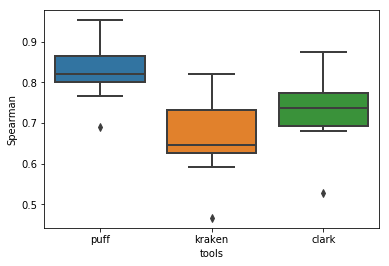



pearson


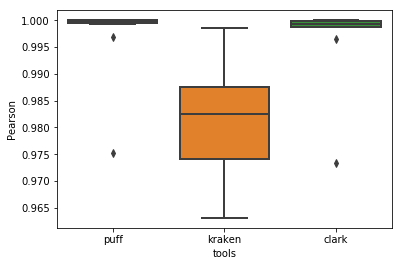



mard


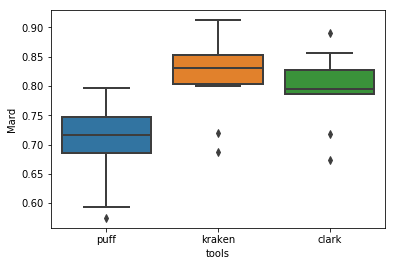



f1


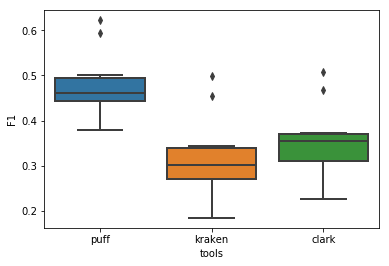



spearman


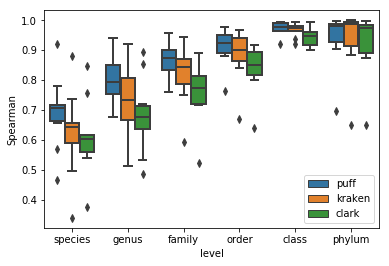



pearson


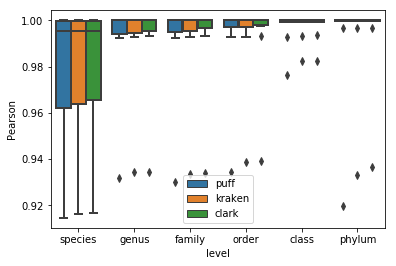



mard


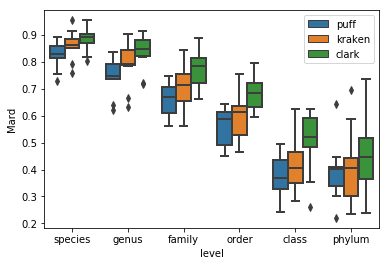



f1


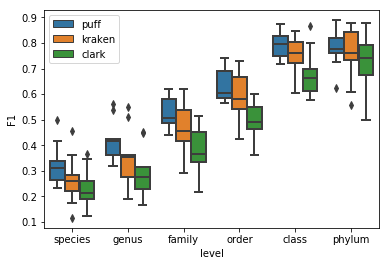



spearman


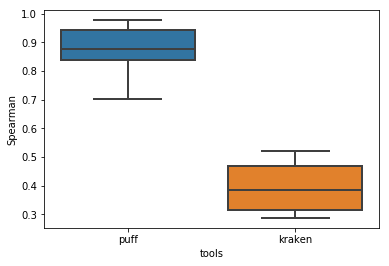



pearson


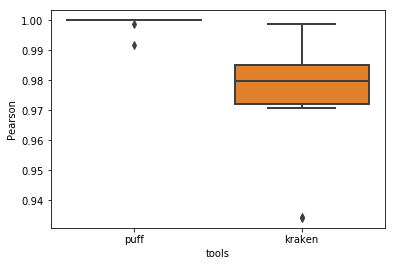



mard


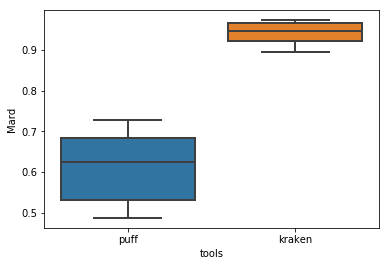



f1


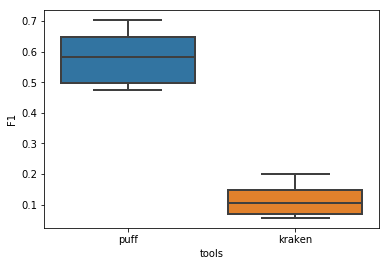

In [537]:
print("\n\nNo Filtering")
clark_df = merge_clark_results('/mnt/scratch2/fatemeh/krakpuff/clark_reports/{}_species.rpt', 
                               '/mnt/scratch2/fatemeh/krakpuff/clark_reports/{}_{}.rpt')
#(stats_df, kraken, puffer) = prepare('/mnt/scratch2/fatemeh/krakpuff/truth_files/{}.truth',
#                                            '/mnt/scratch2/avi/meta-map/kraken/krakOut/{}_unfilt.rpt', 
#                                                  '/mnt/scratch2/fatemeh/krakpuff/{}_species_unfilt.out', 
#                                      clark_df,
#                                      '/mnt/scratch2/fatemeh/krakpuff/statSummary/unfiltered.stat')
#draw_plots(stats_df)
#unpivot_stat = unpivot(stats_df)
#unpivot_stat
levels = ['all']
draw_box_plots(unpivot_stat[unpivot_stat['level'] == 'all'], levels, 'tools', None, '/mnt/scratch2/fatemeh/krakpuff/statSummary/plots/no_filt_all')
levels = ['species', 'genus', 'family', 'order', 'class', 'phylum']
draw_box_plots(unpivot_stat, levels, 'level', 'tools','/mnt/scratch2/fatemeh/krakpuff/statSummary/plots/no_filt_levels')
levels = ['norank']
draw_box_plots(unpivot_stat[unpivot_stat['spearman'] != 0], levels, 'tools', None, '/mnt/scratch2/fatemeh/krakpuff/statSummary/plots/no_filt_norank')

# Filter coverage less than 20 percent normalized by read len



20%
HC1
HC2
LC1
LC2
LC3
LC4
LC5
LC6
LC7
LC8


spearman


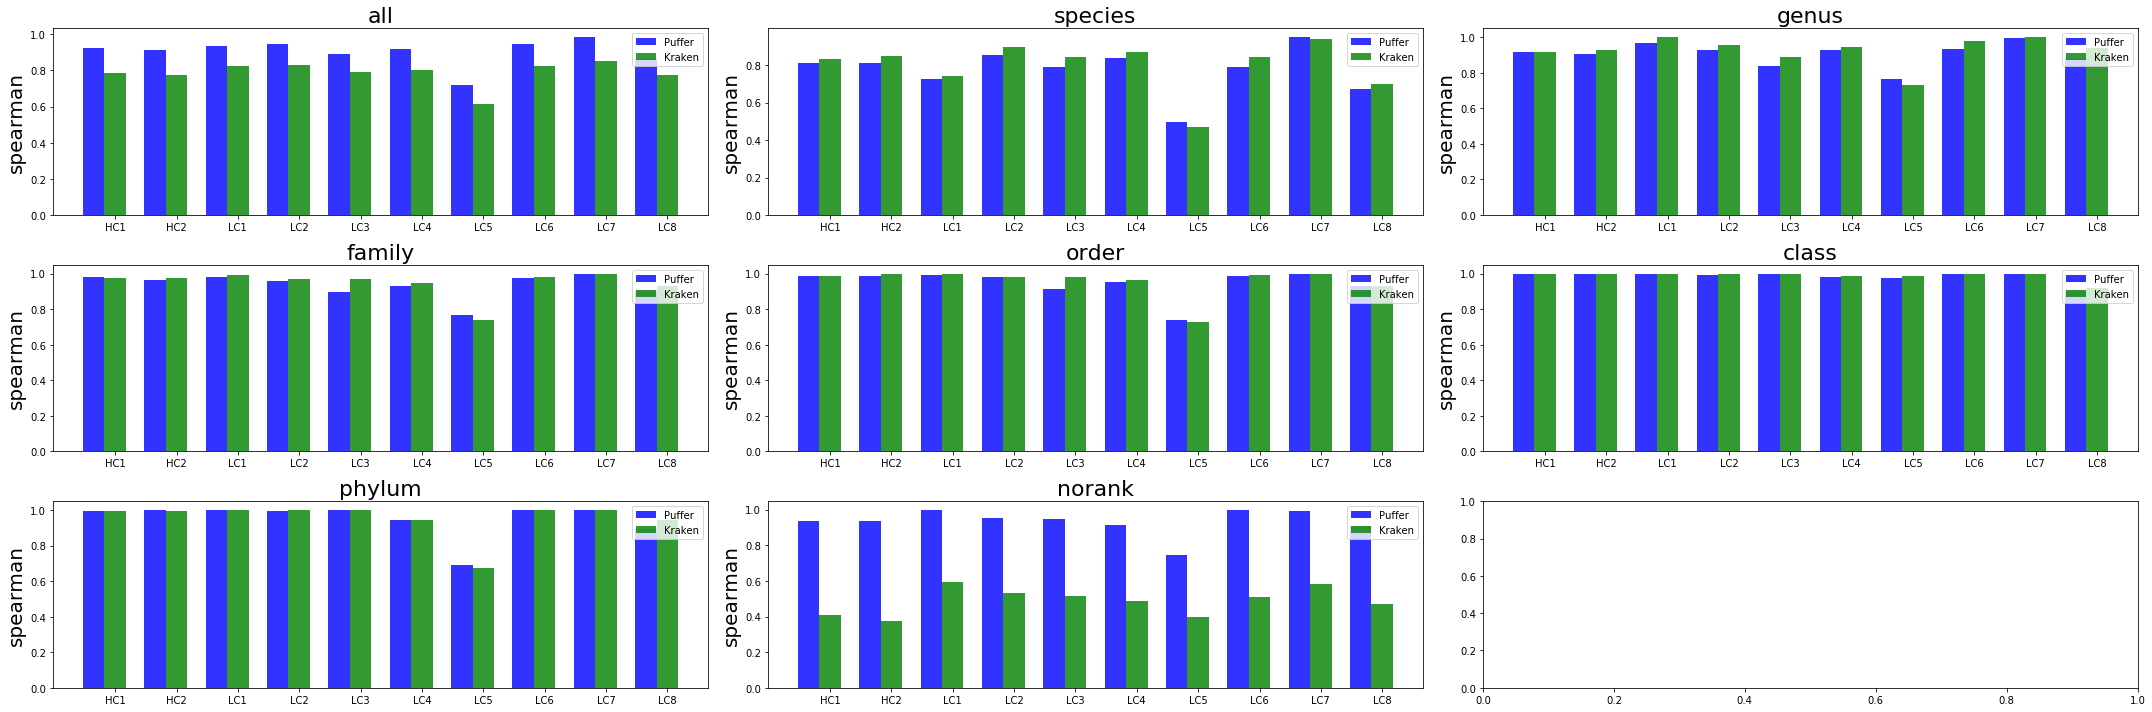



pearson


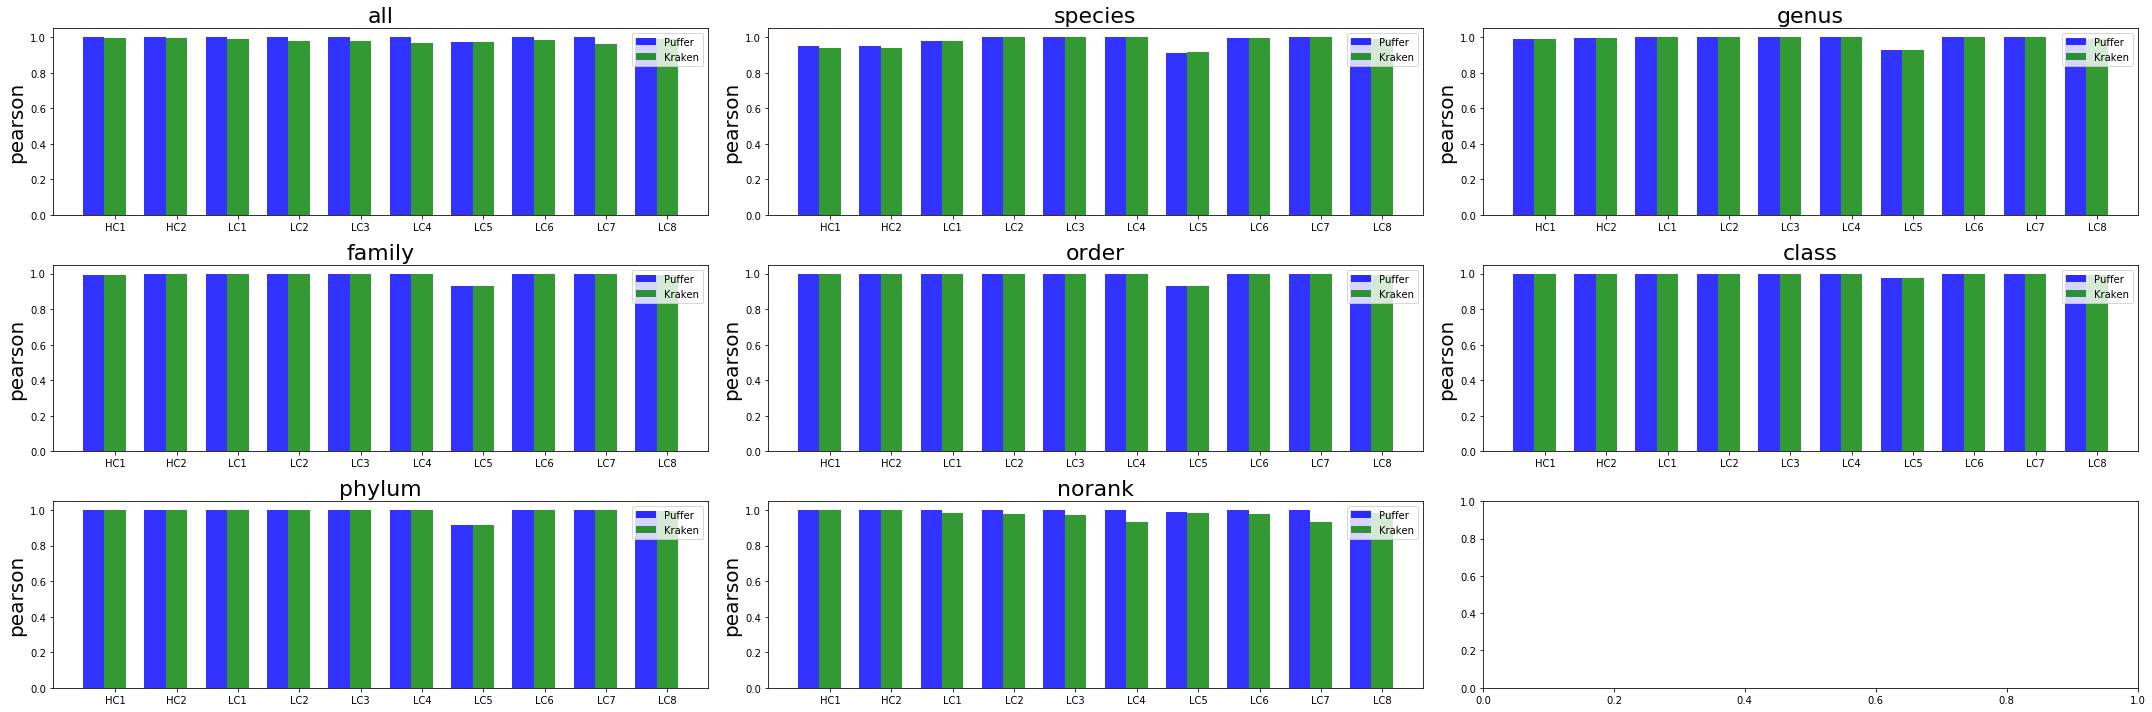



mard


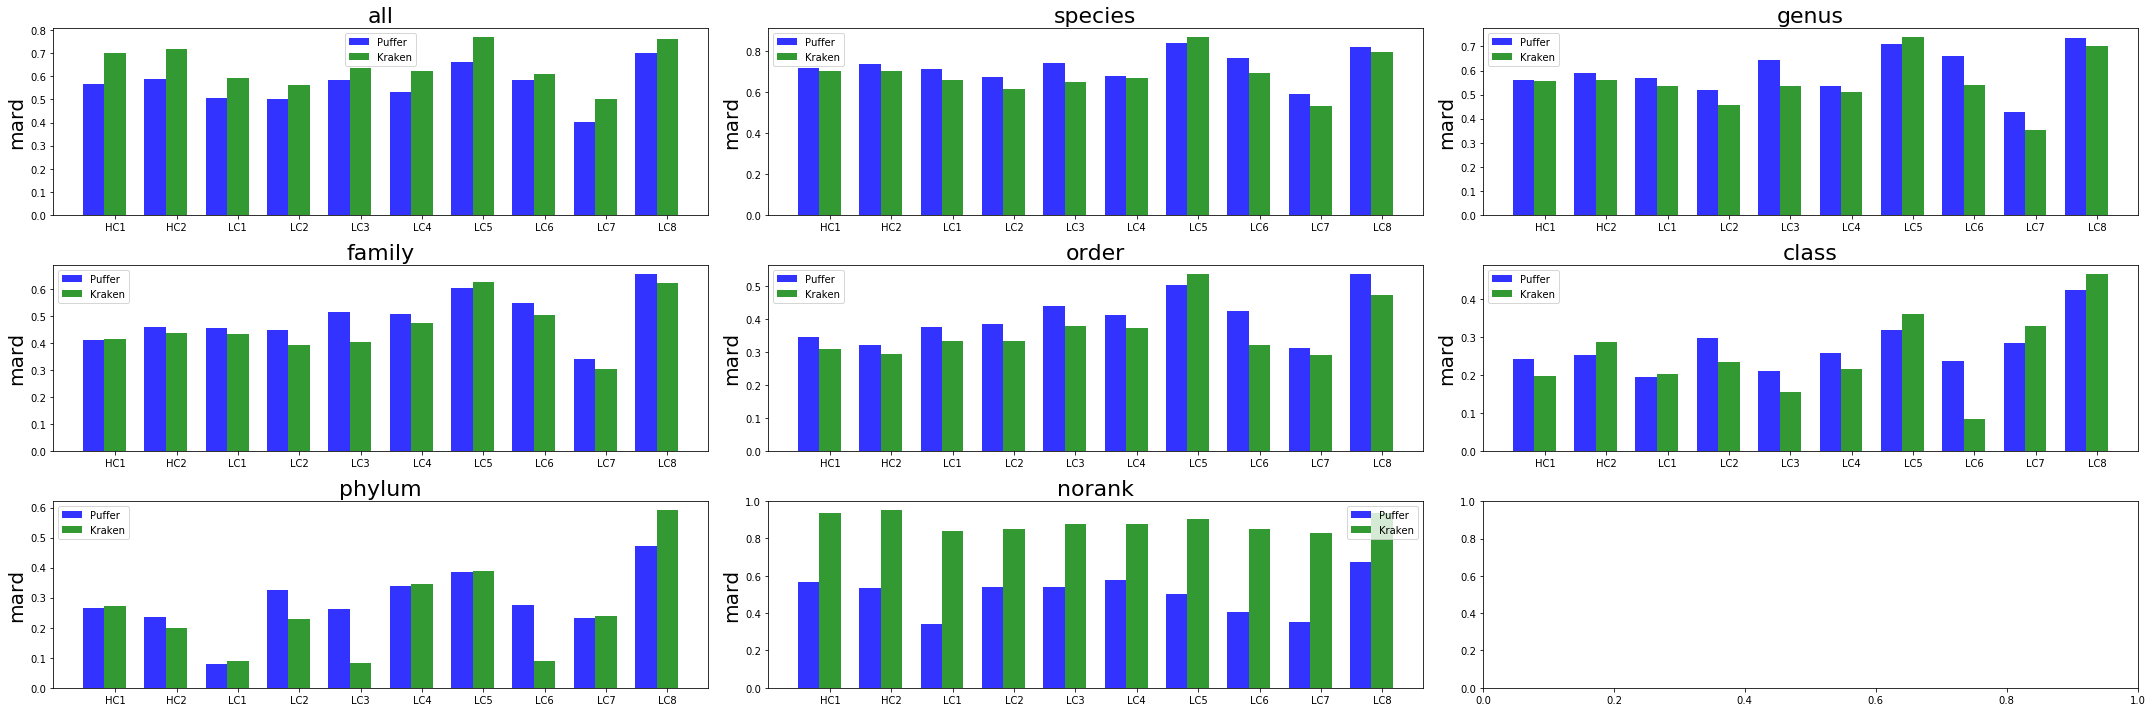



f1


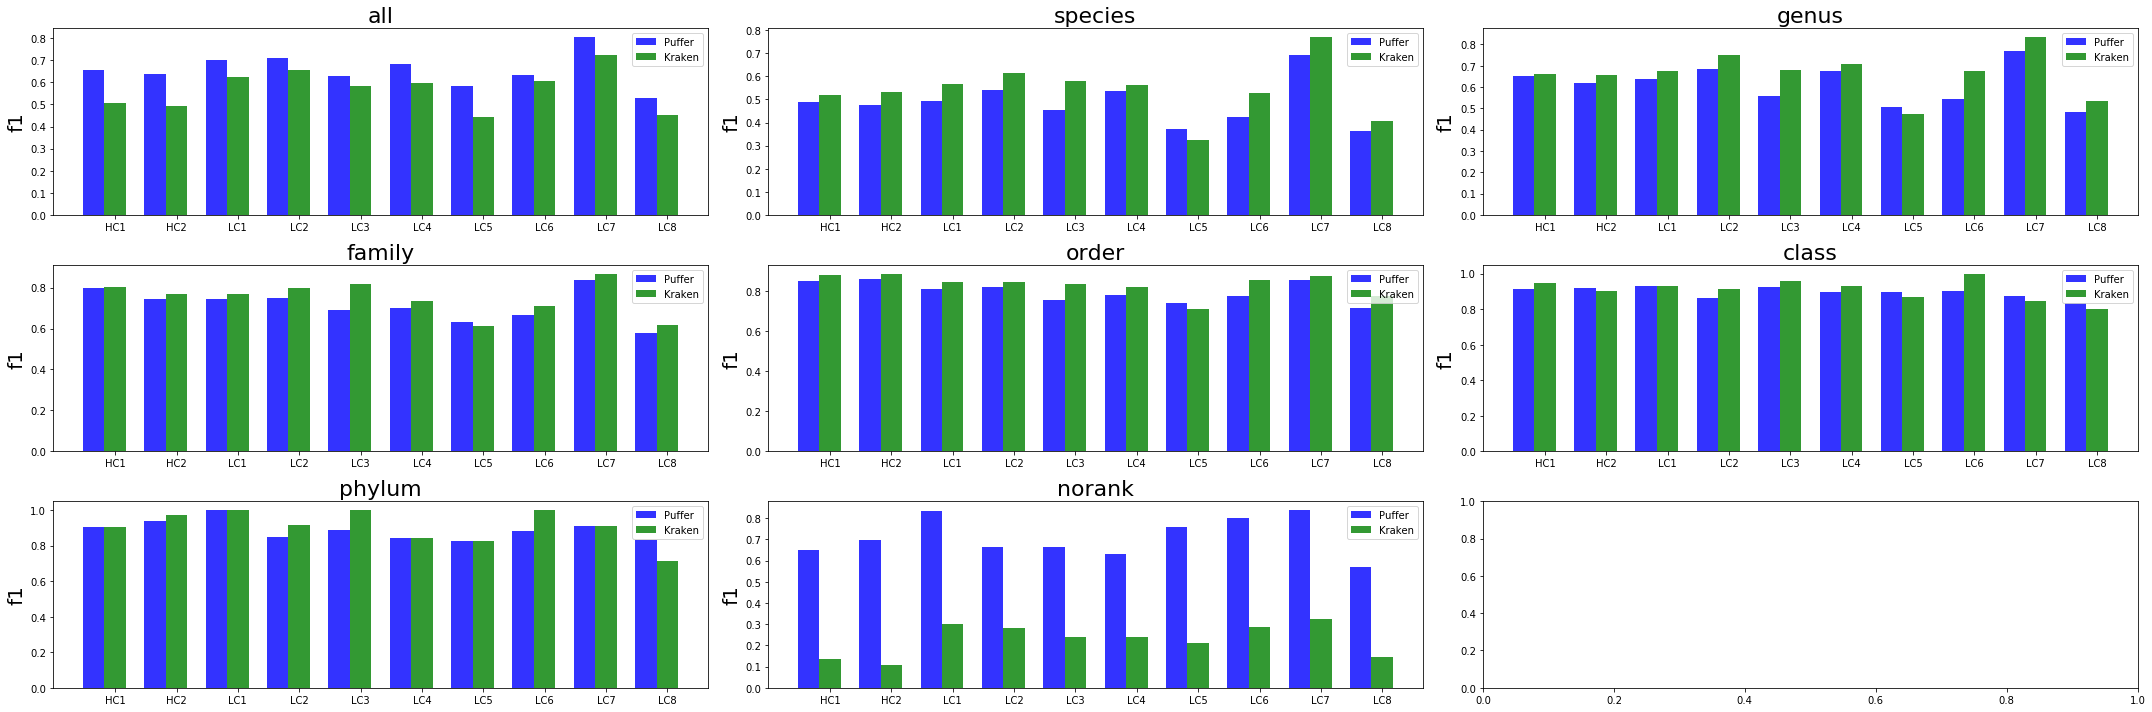



cnt_f1


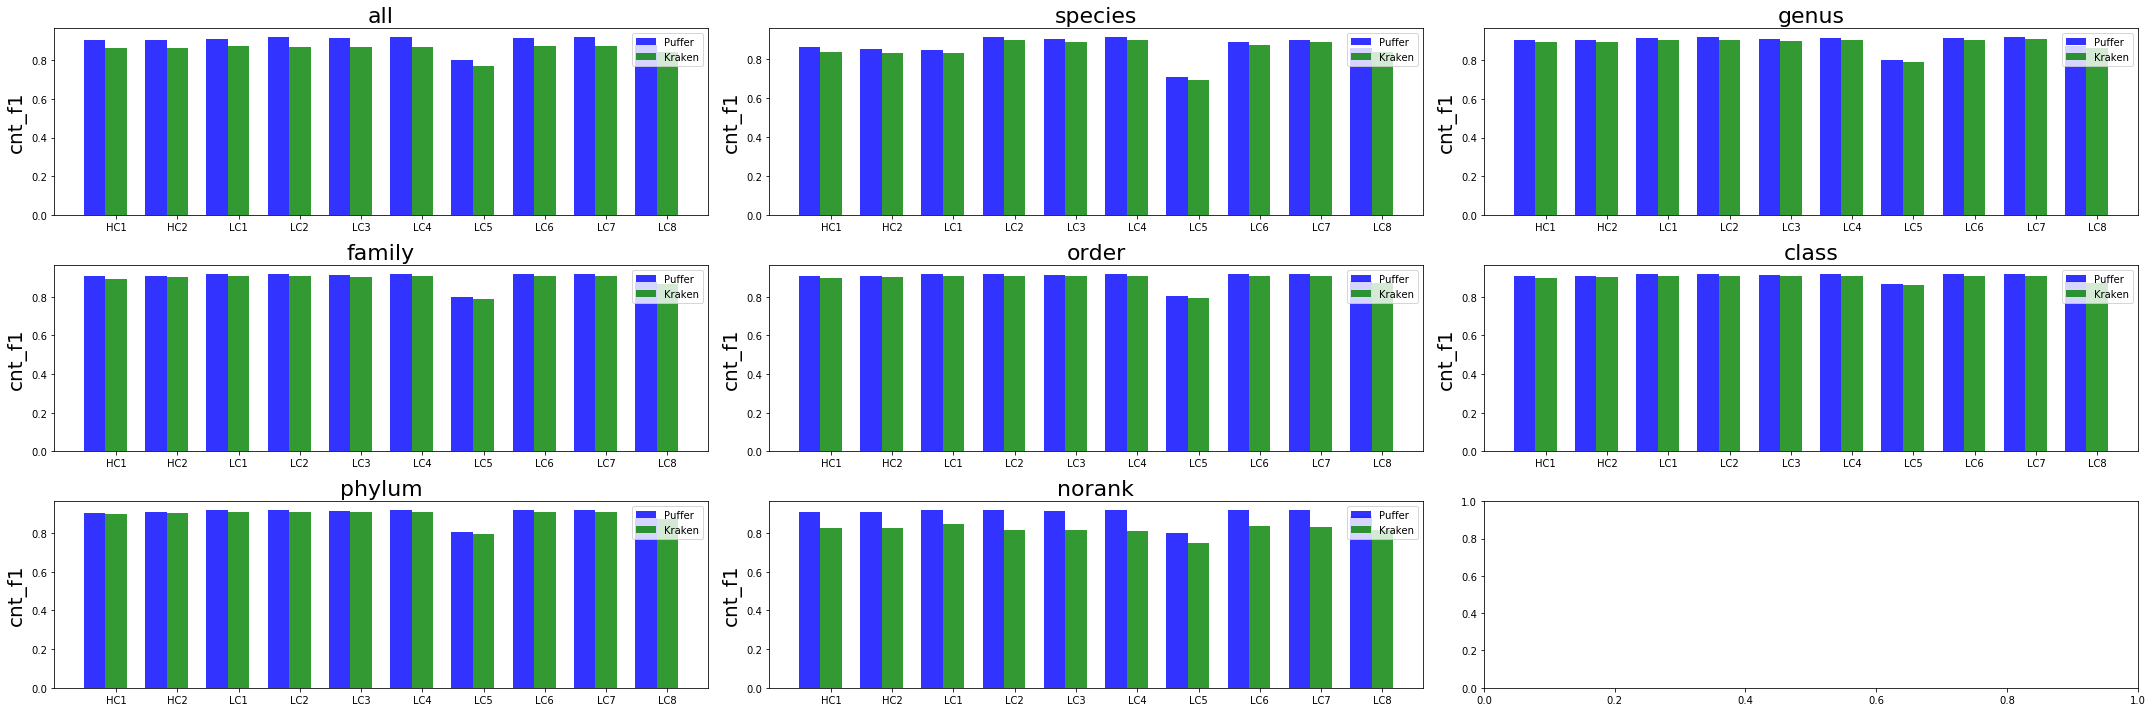

In [254]:
print("\n\n20%")
(stats20_df, kraken20, puffer20) = prepare('/mnt/scratch2/fatemeh/krakpuff/truth_files/{}.truth',
                                           '/mnt/scratch2/avi/meta-map/kraken/krakOut/{}.rpt', 
                                                 '/mnt/scratch2/fatemeh/krakpuff/{}_species0_2.out',
                                           '/mnt/scratch2/avi/meta-map/clark/{}.rpt',
                                    '/mnt/scratch2/fatemeh/krakpuff/statSummary/puff20_krak20.stat')
draw_plots(stats20_df)

# Filter coverage less than 44 nucleotides



44Nuc
HC1
HC2
LC1
LC2
LC3
LC4
LC5
LC6
LC7
LC8


spearman


/home/fatemeh/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


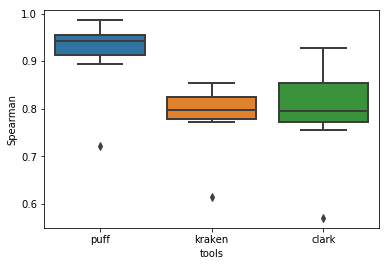



pearson


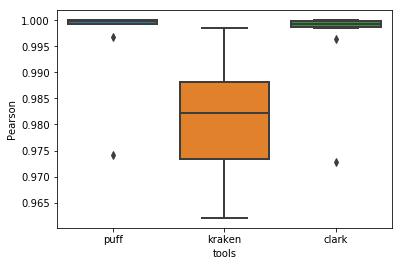



mard


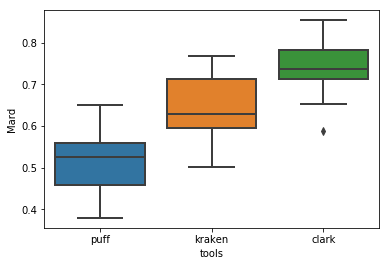



f1


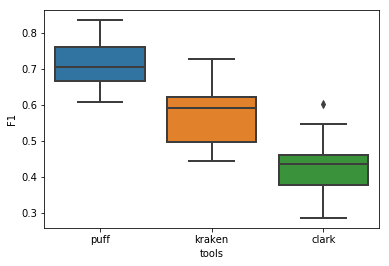



spearman


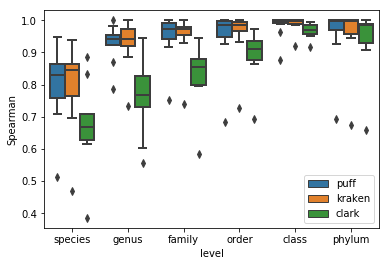



pearson


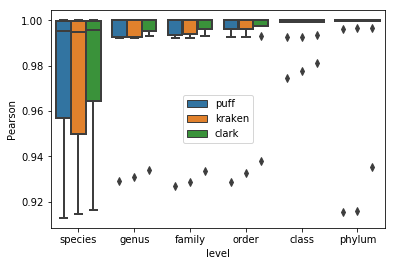



mard


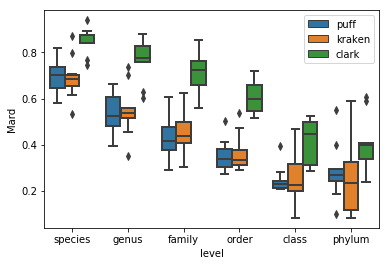



f1


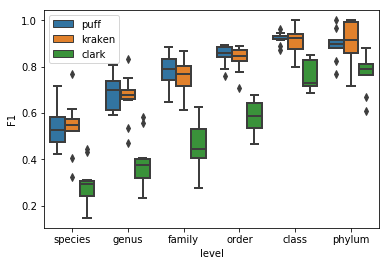



spearman


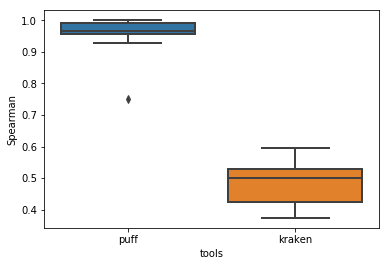



pearson


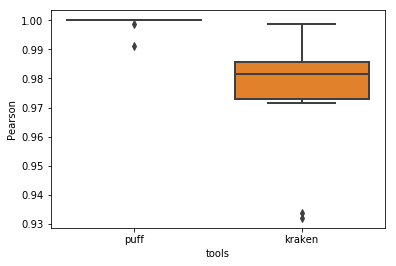



mard


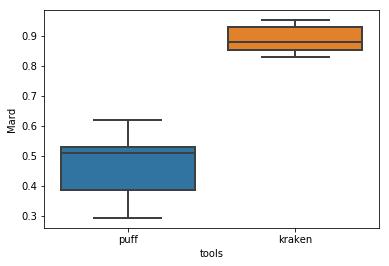



f1


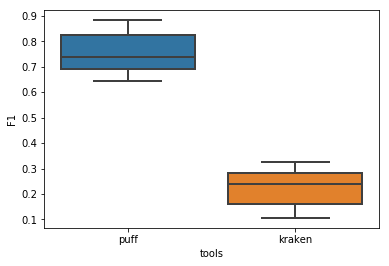

In [22]:
print("\n\n44Nuc")
#clark_filtered_df = merge_clark_results('/mnt/scratch2/fatemeh/krakpuff/clark_reports/{}_species_filtered.rpt', 
#                               '/mnt/scratch2/fatemeh/krakpuff/clark_reports/{}_{}_filtered.rpt')

(stats44_df, kraken20, puffer44) = prepare('/mnt/scratch2/fatemeh/krakpuff/truth_files/{}.truth',
                                           '/mnt/scratch2/avi/meta-map/kraken/krakOut/{}.rpt', 
                                           '/mnt/scratch2/fatemeh/krakpuff/{}_species44.out', 
                                           clark_filtered_df,
                                    '/mnt/scratch2/fatemeh/krakpuff/statSummary/puff44_krak20.stat')
#draw_plots(stats44_df)
#stats44_df
unpivot_stat44 = unpivot(stats44_df)
unpivot_stat44
levels = ['all']
draw_box_plots(unpivot_stat44, levels, 'tools', None, '/mnt/scratch2/fatemeh/krakpuff/statSummary/plots/filt44_all')
levels = ['species', 'genus', 'family', 'order', 'class', 'phylum']
draw_box_plots(unpivot_stat44, levels, 'level', 'tools','/mnt/scratch2/fatemeh/krakpuff/statSummary/plots/filt44_levels')
levels = ['norank']
draw_box_plots(unpivot_stat44[unpivot_stat44['spearman'] != 0], levels, 'tools', None, '/mnt/scratch2/fatemeh/krakpuff/statSummary/plots/filt44_norank')

In [571]:
#clark_filtered_df
tt = pd.merge(clark_filtered_df['HC1'], clark_df['HC1'], left_on=['predId'], right_on=['predId'], how='outer').fillna(0)
tt[['predCount_x', 'predCount_y']].corr(method='spearman')
print('{}, {}'.format(len(stats44_df), len(stats_df)))
t = pd.merge(stats44_df, stats_df, left_on=['level', 'dataset'], right_on=['level', 'dataset'])
t[t['clark_spearman_x'] != t['clark_spearman_y']][['clark_spearman_x', 'clark_spearman_y', 'clark_mard_x', 'clark_mard_y']]
#print(len(t))

80, 80


,clark_spearman_x,clark_spearman_y,clark_mard_x,clark_mard_y
0,0.774005,0.741106,0.762081,0.786294
2,0.663851,0.611742,0.844524,0.868907
3,0.703962,0.683599,0.807562,0.818976
4,0.844987,0.831040,0.689987,0.704391
5,0.918182,0.906415,0.573461,0.596292
6,0.954090,0.945227,0.493516,0.513371
7,0.974714,0.948683,0.449922,0.528504
8,0.768215,0.731000,0.766120,0.793192
10,0.675273,0.617579,0.838554,0.867507
11,0.686685,0.662571,0.814186,0.827613


In [217]:
a = pd.DataFrame.from_csv('/mnt/scratch2/fatemeh/krakpuff/statSummary/before_debug/unfiltered.stat')
b = pd.DataFrame.from_csv('/mnt/scratch2/fatemeh/krakpuff/statSummary/no_repeated_ref/unfiltered.stat')
c = pd.DataFrame.from_csv('/mnt/scratch2/fatemeh/krakpuff/statSummary/skip1/unfiltered.stat')
d = pd.DataFrame.from_csv('/mnt/scratch2/fatemeh/krakpuff/statSummary/unfiltered.stat')

In [201]:
a.head(6)

,dataset,level,puff_pearson,puff_spearman,puff_mard,puff_cnt_prec,puff_cnt_rec,puff_cnt_f1,puff_prec,puff_rec,...,kraken_cnt_rec,kraken_cnt_f1,kraken_prec,kraken_rec,kraken_f1,krakpuff_mard_diff,puffkrak_spearman_diff,puffkrak_pearson_diff,puffkrak_cnt_f1_diff,puffkrak_f1_diff
0,HC1,all,0.999726,0.819785,0.713138,0.999760,0.918042,0.957160,0.305651,0.986188,...,0.919683,0.923420,0.165431,0.986188,0.283333,0.131168,0.191755,0.001221,0.033740,0.183333
1,HC1,species,0.956346,0.691920,0.820025,0.998595,0.843147,0.914311,0.197154,0.970000,...,0.844487,0.914554,0.156200,0.970000,0.269071,0.037050,0.073275,-0.001967,-0.000243,0.058632
2,HC1,genus,0.993907,0.774309,0.749951,0.999484,0.922207,0.959292,0.260417,0.974026,...,0.922971,0.959371,0.217391,0.974026,0.355450,0.041006,0.065952,-0.000188,-0.000079,0.055509
3,HC1,family,0.994245,0.904803,0.609469,0.999776,0.923717,0.960242,0.416149,1.000000,...,0.924990,0.960815,0.374302,1.000000,0.544715,0.038910,0.029599,-0.000270,-0.000573,0.043004
4,HC1,order,0.996273,0.950263,0.492391,0.999899,0.924848,0.960910,0.539326,1.000000,...,0.926405,0.961725,0.505263,1.000000,0.671329,0.031526,0.009694,-0.000160,-0.000814,0.029401
5,HC1,class,0.999387,0.979559,0.392751,0.999974,0.925808,0.961463,0.634146,1.000000,...,0.927662,0.962456,0.619048,1.000000,0.764706,0.014195,0.005669,-0.000015,-0.000993,0.011414


In [246]:
kkk = c.puff_mard-b.puff_mard
kkk[kkk != 0]

0     0.019160
1     0.013405
2     0.017190
3     0.018631
4     0.026917
5     0.053939
6     0.092662
7     0.011009
8     0.007769
9     0.013136
10    0.015578
11    0.011574
12   -0.000024
13   -0.000019
14    0.032237
15    0.020543
16    0.025137
17    0.023831
18    0.024594
19    0.137690
20    0.222695
21   -0.000271
22    0.017137
23   -0.005662
24   -0.008366
25   -0.000497
26   -0.030833
27   -0.044688
28    0.022110
29    0.007670
        ...   
40   -0.038124
41   -0.044209
42    0.011825
43    0.007413
44    0.006312
45    0.022841
46    0.008073
47   -0.037894
48   -0.000070
49    0.010580
50    0.002042
51    0.013028
52    0.004120
53    0.021726
54    0.020855
55   -0.000244
56   -0.045677
57   -0.037883
58   -0.046723
59   -0.037429
60   -0.041545
61    0.000091
62   -0.053435
63    0.008436
64    0.002865
65    0.006488
66    0.015254
67    0.022575
68    0.000043
69   -0.035659
Name: puff_mard, Length: 70, dtype: float64

In [188]:
after_bug = {}
with open('/mnt/scratch2/fatemeh/krakpuff/mapping_dmps/LC4.dmp') as f:
    line = f.readline()
    while line:
        splitted = line.split()
        l = []
        for i in range(int(splitted[1])):
            line = f.readline()
            l += [line.split()[0]]
        #if (splitted[0] in after_bug):
        #    print('shouldnt {}'.format(splitted[0]))
        after_bug[splitted[0]] = l
        line = f.readline()       

In [191]:
before_bug = {}
with open('/mnt/scratch2/LC4.dmp') as f:
    line = f.readline()
    while line:
        splitted = line.split()
        l = []
        for i in range(int(splitted[1])):
            line = f.readline()
            l += [line.split()[0]]
        before_bug[splitted[0]] = l
        line = f.readline()

In [192]:
for k, v in after_bug.items():
    if len(before_bug[k]) != len(v):
        print('{}:{},{}'.format(k, len(before_bug[k]), len(v)))

pzu_111491_111670_8e62b:0,1
pzu_2703637_2703793_153bd:0,1
pzu_1255774_1255944_3d32d:0,1
pzu_2945802_2945978_2dd40:1,0
pzu_1484500_1484678_89975:0,1
pzu_2750703_2750884_36398:1,0
pzu_3324642_3324789_706ef:1,0
pzu_68754_68901_60ed6:0,1
pzu_1563937_1564121_118dc:0,1
pzu_1211775_1211974_252b3:0,1
pzu_3540931_3541097_a019d:0,1
pzu_1926279_1926470_2218b:2,1
har_1949026_1949213_198c9:1,0
xca_294301_294475_7dd0:2,1
pzu_1676826_1676998_4d651:1,0


In [193]:
print(after_bug['pzu_111491_111670_8e62b'])
print(before_bug['pzu_111491_111670_8e62b'])

['gi|197103466|ref|NC_011144.1|']
[]


In [ ]:
clark_hc1 = pd.read_csv('/mnt/scratch2/avi/meta-map/clark/HC1.rpt')

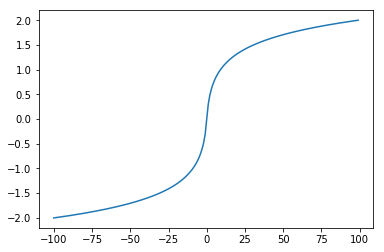

In [243]:
def sign(a):
    if a > 0:
        return 1
    if a <= 0:
        return -1
difference = list(range(-100, 100, 1))

log_modulus = [sign(x)*log(abs(x)+1, 10) for x in difference]
plt.plot(difference, log_modulus)

In [313]:
clark_df = pd.read_csv('/mnt/scratch2/avi/meta-map/clark/HC1.rpt')
clark_df['TaxID'] = clark_df['TaxID'].apply(pd.to_numeric, errors='coerce')
clark_df['TaxID'] = clark_df['TaxID'].fillna(0.0).astype(int)
clark_df.dtypes

Name                         object
TaxID                         int64
Lineage                      object
Count                         int64
Proportion_All(%)           float64
Proportion_Classified(%)     object
dtype: object

In [315]:
print(len(clark_df))
c_df = pd.merge(clark_df, taxa_df, left_on='TaxID', right_on='taxaId')
print(len(c_df))
print(c_df.dtypes)

682
681
Name                         object
TaxID                         int64
Lineage                      object
Count                         int64
Proportion_All(%)           float64
Proportion_Classified(%)     object
taxaId                        int64
pid                           int64
rank                         object
dtype: object


In [321]:
c_df.groupby('rank').count()

,Name,TaxID,Lineage,Count,Proportion_All(%),Proportion_Classified(%),taxaId,pid
rank,,,,,,,,
species,681,681,681,681,681,681,681,681


In [345]:
clark_mapping = pd.read_csv('/mnt/scratch2/avi/meta-map/clark/HC1.csv')
clark_mapping.columns = ['readId', 'readLen', 'predId']
clark_mapping.head()

,readId,readLen,predId
0,taf_993394_993580_3f3dc/1,51,NaN
1,lps_1012348_1012526_c9a0/2,100,1590.0
2,vpa.II_1755137_1755333_409/1,100,670.0
3,mac_4502468_4502637_321a9/2,100,2214.0
4,xca_1318293_1318458_4af66/2,74,339.0


In [347]:
clark_mapping_ = pd.merge(clark_mapping, taxa_df, left_on='predId', right_on='taxaId')

In [348]:
clark_mapping_['rank'].unique()

array(['species'], dtype=object)

In [367]:
k1 = pd.read_csv('/mnt/scratch2/avi/meta-map/kraken/krakOut/{}.rpt'.format('HC1'), sep='\t', header=None)
k2 = pd.read_csv('/home/fatemeh/others_projects/mason_eval/species/Huttenhower_HC1_KrakenFiltered.txt', sep='\t', header=None)
k1.columns=['totperc', 'totCnt', 'k1cnt', 'typ', 'k1id', 'name']
k2.columns=['k2id', 'k2cnt', 'perc', 'k2rank', 'name']
k1 = pd.merge(k1, taxa_df, left_on='k1id', right_on='taxaId')
print(k1.head(5))
print(k2.head(5))

   totperc  totCnt  k1cnt typ    k1id                         name  taxaId  \
0    81.50  814977      0   -       1                         root       1   
1    81.50  814977     22   -  131567           cellular organisms  131567   
2    76.26  762643    841   D       2                     Bacteria       2   
3    38.06  380612   1006   P    1224               Proteobacteria    1224   
4    18.78  187808    564   C    1236          Gammaproteobacteria    1236   

      pid          rank  
0       1       no rank  
1       1       no rank  
2  131567  superkingdom  
3       2        phylum  
4    1224         class  
     k2id    k2cnt     perc   k2rank                         name
0   79329  20440.0  0.02448  species        Chitinophaga pinensis
1    1836  18431.0  0.02207  species  Saccharopolyspora erythraea
2  182640  16905.0  0.02025  species            Kribbella flavida
3  152480  13938.0  0.01669  species       Burkholderia ambifaria
4     986  13660.0  0.01636  species    Flavo

In [368]:
print(len(k2))
k1_species = k1[k1["rank"] == 'species']
print(len(k1))
print(len(k1_species))

252
1043
272


In [372]:
k1k2 = pd.merge(k1_species, k2, left_on='k1id', right_on='k2id', how='outer').fillna(0)
k1k2[['k1id', 'k2id', 'rank', 'k2rank', 'k1cnt', 'totCnt', 'k2cnt']]

,k1id,k2id,rank,k2rank,k1cnt,totCnt,k2cnt
0,470934.0,470934.0,species,species,0.0,10813.0,10812.0
1,553.0,553.0,species,species,8491.0,10349.0,10352.0
2,592316.0,592316.0,species,species,1.0,1.0,1.0
3,9.0,9.0,species,species,0.0,1.0,1.0
4,28151.0,28151.0,species,species,0.0,11279.0,11277.0
5,614.0,614.0,species,species,0.0,8.0,8.0
6,615.0,615.0,species,species,1.0,3.0,2.0
7,82996.0,82996.0,species,species,1.0,2.0,2.0
8,244366.0,244366.0,species,species,0.0,2601.0,2605.0
9,573.0,573.0,species,species,17.0,28.0,28.0


In [373]:
k1k2['k1k2_diff'] = k1k2['totCnt'] - k1k2['k2cnt']
k1k2[k1k2['k1k2_diff'] != 0][['k1id', 'k2id', 'totCnt', 'k2cnt', 'k1k2_diff']]

,k1id,k2id,totCnt,k2cnt,k1k2_diff
0,470934.0,470934.0,10813.0,10812.0,1.0
1,553.0,553.0,10349.0,10352.0,-3.0
4,28151.0,28151.0,11279.0,11277.0,2.0
6,615.0,615.0,3.0,2.0,1.0
8,244366.0,244366.0,2601.0,2605.0,-4.0
10,548.0,548.0,2.0,1.0,1.0
11,1134687.0,0.0,2.0,0.0,2.0
15,28901.0,28901.0,1.0,2.0,-1.0
18,636.0,636.0,1711.0,1710.0,1.0
22,680.0,680.0,13050.0,13023.0,27.0


In [377]:
hc11 = pd.read_csv('~/others_projects/mason_eval/benchmarking_metagenomic_classifiers.git/truth/Huttenhower_HC1_abund.txt', sep='\t')

In [401]:
totalCnt = truth[truth['dataset'] == 'Huttenhower_HC1'].counts.sum()
truth['fraction'] = truth['counts']/totalCnt
truth['level'] = 'species'
#truth.head()
toSave=truth[['taxid', 'counts', 'fraction', 'level', 'species']]
toSave.to_csv('~/others_projects/mason_eval/benchmarking_metagenomic_classifiers.git/truth/species_Huttenhower_HC1_abund.txt', sep='\t', header=None, index=False)

In [400]:
k1 = pd.read_csv('/mnt/scratch2/avi/meta-map/kraken/krakOut/{}.rpt'.format('HC1'), sep='\t', header=None)
k1.columns=['totperc', 'totCnt', 'k1cnt', 'typ', 'k1id', 'name']
k1 = pd.merge(k1, taxa_df, left_on='k1id', right_on='taxaId')
k1.head()
k1['totperc'] = k1['totperc']/100
k1[k1['rank'] == 'species'][['taxaId', 'totCnt', 'totperc', 'rank', 'name']].to_csv('~/others_projects/mason_eval/benchmarking_metagenomic_classifiers.git/dataset/species_HC1_kraken.txt', 
       sep='\t', header=None, index=False)